## Root Cause Analysis

In [1]:
import pandas as pd
import numpy as np 

In [ ]:
!pip install dowhy

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('root_cause_analysis.csv')
display(df.head(5))

,ID,CPU_LOAD,MEMORY_LOAD,DELAY,ERROR_1000,ERROR_1001,ERROR_1002,ERROR_1003,ROOT_CAUSE
0,1,0,0,0,0,1,0,1,MEMORY
1,2,0,0,0,0,0,0,1,MEMORY
2,3,0,1,1,0,0,1,1,MEMORY
3,4,0,1,0,1,1,0,1,MEMORY
4,5,1,1,0,1,0,1,0,NETWORK_DELAY


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           1000 non-null   int64 
 1   CPU_LOAD     1000 non-null   int64 
 2   MEMORY_LOAD  1000 non-null   int64 
 3   DELAY        1000 non-null   int64 
 4   ERROR_1000   1000 non-null   int64 
 5   ERROR_1001   1000 non-null   int64 
 6   ERROR_1002   1000 non-null   int64 
 7   ERROR_1003   1000 non-null   int64 
 8   ROOT_CAUSE   1000 non-null   object
dtypes: int64(8), object(1)
memory usage: 70.4+ KB


Determining which factors (CPU_LOAD, MEMORY_LOAD, DELAY) cause each of the four errors.

In [26]:
import dowhy 

#### For Error_1000

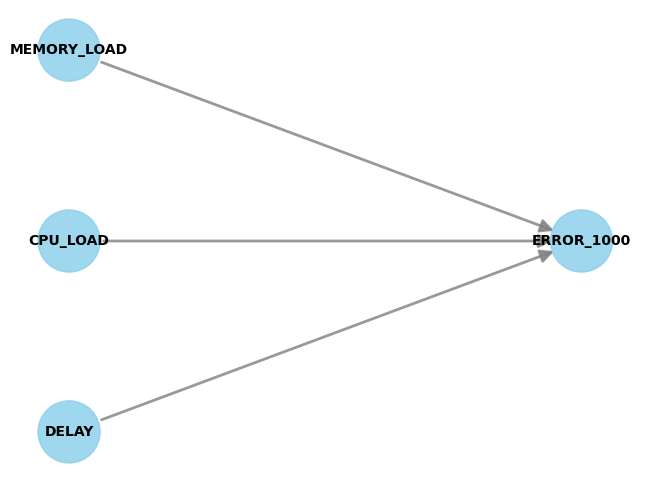

In [27]:
model_error1000 = dowhy.CausalModel(
    data=df,
    treatment=['CPU_LOAD', 'MEMORY_LOAD', 'DELAY'],
    outcome='ERROR_1000'
)
model_error1000.view_model() 

In [28]:
identified_estimand = model_error1000.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
               d                             
───────────────────────────────(E[ERROR₁₀₀₀])
d[CPU_LOAD  MEMORY_LOAD  DELAY]              
Estimand assumption 1, Unconfoundedness: If U→{CPU_LOAD,MEMORY_LOAD,DELAY} and U→ERROR_1000 then P(ERROR_1000|CPU_LOAD,MEMORY_LOAD,DELAY,,U) = P(ERROR_1000|CPU_LOAD,MEMORY_LOAD,DELAY,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [29]:
estimate = model_error1000.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
               d                             
───────────────────────────────(E[ERROR₁₀₀₀])
d[CPU_LOAD  MEMORY_LOAD  DELAY]              
Estimand assumption 1, Unconfoundedness: If U→{CPU_LOAD,MEMORY_LOAD,DELAY} and U→ERROR_1000 then P(ERROR_1000|CPU_LOAD,MEMORY_LOAD,DELAY,,U) = P(ERROR_1000|CPU_LOAD,MEMORY_LOAD,DELAY,)

## Realized estimand
b: ERROR_1000~CPU_LOAD+MEMORY_LOAD+DELAY
Target units: ate

## Estimate
Mean value: 0.10616994086399795



In [30]:
refute_error1000 = model_error1000.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(refute_error1000)

Refute: Add a random common cause
Estimated effect:0.10616994086399795
New effect:0.10604518167317373
p value:0.92



## Using NN for Root Cause Analysis 

In [78]:
df2 = df.copy()
df2 = df2.drop(['result'], axis=1)
df2.columns 

Index(['ID', 'CPU_LOAD', 'MEMORY_LOAD', 'DELAY', 'ERROR_1000', 'ERROR_1001',
       'ERROR_1002', 'ERROR_1003', 'ROOT_CAUSE'],
      dtype='object')

In [79]:
df.result.unique()

array([1, 2, 0])

In [80]:
from sklearn import preprocessing
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn 

label_encoder = preprocessing.LabelEncoder()
df2['ROOT_CAUSE'] = label_encoder.fit_transform(df2['ROOT_CAUSE'])

In [82]:
df_arr = df2.to_numpy().astype(float)

X = df_arr[:, 1:8]
y = df_arr[:, 8]
X.shape, y.shape

In [84]:
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.long)

In [86]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 7]),
 torch.Size([200, 8]),
 torch.Size([800]),
 torch.Size([200]))

In [87]:
class ModelNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(ModelNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  
        self.fc2 = nn.Linear(128, 128)          
        self.fc3 = nn.Linear(128, output_size)  

    def forward(self, x):
        x = torch.relu(self.fc1(x))   
        x = torch.relu(self.fc2(x))   
        x = torch.softmax(self.fc3(x), dim=1)  
        return x

In [97]:
EPOCHS = 200
BATCH_SIZE = 100
OUTPUT_CLASSES = len(label_encoder.classes_)

model = ModelNN(input_size=X_train.shape[1], output_size=OUTPUT_CLASSES)
model

ModelNN(
  (fc1): Linear(in_features=7, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)

In [98]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [99]:
for epoch in range(EPOCHS):
    model.train()  
    for i in range(0, len(X_train), BATCH_SIZE):
        
        X_batch = X_train[i:i + BATCH_SIZE]
        y_batch = y_train[i:i + BATCH_SIZE]

        optimizer.zero_grad()

        
        outputs = model(X_batch)
        
        loss = criterion(outputs, y_batch)
        
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()  
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        _, predicted = torch.max(val_outputs, 1)
        val_accuracy = (predicted == y_val).sum().item() / len(y_val)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch [1/200], Loss: 1.1021, Validation Loss: 1.0985, Validation Accuracy: 0.3200
Epoch [2/200], Loss: 1.1012, Validation Loss: 1.0975, Validation Accuracy: 0.3200
Epoch [3/200], Loss: 1.1003, Validation Loss: 1.0966, Validation Accuracy: 0.3200
Epoch [4/200], Loss: 1.0995, Validation Loss: 1.0957, Validation Accuracy: 0.3200
Epoch [5/200], Loss: 1.0986, Validation Loss: 1.0948, Validation Accuracy: 0.3200
Epoch [6/200], Loss: 1.0978, Validation Loss: 1.0939, Validation Accuracy: 0.3200
Epoch [7/200], Loss: 1.0969, Validation Loss: 1.0929, Validation Accuracy: 0.3200
Epoch [8/200], Loss: 1.0960, Validation Loss: 1.0920, Validation Accuracy: 0.3200
Epoch [9/200], Loss: 1.0952, Validation Loss: 1.0911, Validation Accuracy: 0.3200
Epoch [10/200], Loss: 1.0943, Validation Loss: 1.0902, Validation Accuracy: 0.3200
Epoch [11/200], Loss: 1.0935, Validation Loss: 1.0892, Validation Accuracy: 0.3200
Epoch [12/200], Loss: 1.0926, Validation Loss: 1.0883, Validation Accuracy: 0.3250
Epoch [13/200

In [104]:
CPU_LOAD = 1
MEMORY_LOAD = 0
DELAY = 1
ERROR_1000 = 0
ERROR_1001 = 0
ERROR_1002 = 0
ERROR_1003 = 1

input_data = torch.tensor([[CPU_LOAD, MEMORY_LOAD, DELAY,
                             ERROR_1000, ERROR_1001, ERROR_1002, ERROR_1003]], 
                           dtype=torch.float32)
model.eval()

with torch.no_grad():  
    prediction_logits = model(input_data)  
    prediction = torch.argmax(prediction_logits, dim=1)  

predicted_root_cause = label_encoder.inverse_transform(prediction.numpy())

print(f"Predicted Root Cause: {predicted_root_cause[0]}")

Predicted Root Cause: MEMORY
